# OCR Libraries Time Comparison

This notebook compares the performance of different OCR libraries for extracting text from images within PDF documents.

In [1]:
# Install required packages
import subprocess
import sys

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Uncomment the following lines to auto-install packages
# install_package("pdfplumber")
# install_package("pandas")
# install_package("matplotlib")
# install_package("Pillow")
# install_package("numpy")
# install_package("easyocr")
# install_package("paddlepaddle")
# install_package("paddleocr")
# install_package("transformers")
# install_package("torch")
# install_package("torchvision")

import pdfplumber
import time
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import io
import numpy as np
from collections import defaultdict
import os
import glob
import subprocess

# OCR libraries
try:
    import easyocr
    EASYOCR_AVAILABLE = True
except ImportError:
    EASYOCR_AVAILABLE = False
    print("EasyOCR not available")

try:
    from paddleocr import PaddleOCR
    PADDLEOCR_AVAILABLE = True
except ImportError:
    PADDLEOCR_AVAILABLE = False
    print("PaddleOCR not available")

# Fast OCR alternatives
try:
    from transformers import TrOCRProcessor, VisionEncoderDecoderModel
    import torch
    TROCR_AVAILABLE = True
except ImportError:
    TROCR_AVAILABLE = False
    print("TrOCR not available")

try:
    import cv2
    OPENCV_AVAILABLE = True
except ImportError:
    OPENCV_AVAILABLE = False
    print("OpenCV not available for preprocessing")

/home/nahuel/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class PDFTextExtractorWithOCR:
    def __init__(self):
        # Initialize OCR engines
        self.ocr_engines = {}
        
        if EASYOCR_AVAILABLE:
            self.ocr_engines['easyocr'] = easyocr.Reader(['en', 'es'])
        
        if PADDLEOCR_AVAILABLE:
            # PaddleOCR with Spanish language support
            self.ocr_engines['paddleocr'] = PaddleOCR(use_textline_orientation=True, lang='es')
        
        # Initialize TrOCR (fastest for printed text)
        if TROCR_AVAILABLE:
            self.ocr_engines['trocr_processor'] = TrOCRProcessor.from_pretrained('microsoft/trocr-base-printed')
            self.ocr_engines['trocr_model'] = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-printed')
            
            # Use GPU if available
            self.device = "cuda" if torch.cuda.is_available() else "cpu"
            self.ocr_engines['trocr_model'].to(self.device)
    
    def get_fontsizes(self, pdf_path):
        """Extract font sizes from PDF to determine appropriate tags"""
        sizes = []
        with pdfplumber.open(pdf_path) as pdf:
            for page in pdf.pages:
                words = page.extract_words()
                for word in words:
                    if 'height' in word:
                        sizes.append(round(float(word['height'])))
        
        if not sizes:
            return {"p": 12}
        
        # Create mapping of font sizes to tags
        unique_sizes = sorted(list(set(sizes)), reverse=True)
        size_mapping = {}
        
        for i, size in enumerate(unique_sizes):
            if i == 0:
                size_mapping[size] = "h1"
            elif i == 1:
                size_mapping[size] = "h2"
            elif i == 2:
                size_mapping[size] = "h3"
            else:
                size_mapping[size] = "p"
        
        return size_mapping
    
    def get_correct_tag(self, fontsize, sizes_dict):
        """Get appropriate HTML tag for given font size"""
        return sizes_dict.get(fontsize, "p")
    
    def preprocess_image(self, image):
        """Preprocess image for better OCR results"""
        if not OPENCV_AVAILABLE:
            return image
        
        # Convert PIL to OpenCV format
        img_array = np.array(image)
        
        # Convert to grayscale
        if len(img_array.shape) == 3:
            gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
        else:
            gray = img_array
        
        # Apply threshold to get better contrast
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Convert back to PIL
        return Image.fromarray(thresh)
    
    def extract_text_from_image_easyocr(self, image):
        """Extract text using EasyOCR"""
        if 'easyocr' not in self.ocr_engines:
            return ""
        
        # Convert PIL image to numpy array
        img_array = np.array(image)
        results = self.ocr_engines['easyocr'].readtext(img_array)
        return ' '.join([result[1] for result in results])
    
    def extract_text_from_image_paddleocr(self, image):
        """Extract text using PaddleOCR - CORRECTED VERSION using proper result parsing"""
        if 'paddleocr' not in self.ocr_engines:
            return ""
        
        try:
            # Convert PIL image to numpy array  
            img_array = np.array(image)
            
            # Use predict() method - this works with the correct result structure
            result = self.ocr_engines['paddleocr'].predict(img_array)
            
            # Use the correct parsing pattern from paddletest.py
            if result and result[0]:
                data = result[0]  # Get the dictionary from result
                
                if isinstance(data, dict) and "rec_texts" in data:
                    texts = data["rec_texts"]
                    return ' '.join(texts)
                else:
                    print(f"    🔍 DEBUG: Data keys: {list(data.keys()) if isinstance(data, dict) else 'Not a dict'}")
                    
            print(f"    🔍 DEBUG: Could not extract text, result structure: {result}")
            return ""
            
        except Exception as e:
            print(f"    ❌ PaddleOCR predict error: {e}")
            return ""
    
    def extract_text_from_image_trocr(self, image):
        """Extract text using TrOCR (Microsoft's Transformer OCR - very fast)"""
        if 'trocr_processor' not in self.ocr_engines:
            return ""
        
        try:
            # Convert to RGB if needed
            if image.mode != 'RGB':
                image = image.convert('RGB')
            
            # Process image
            pixel_values = self.ocr_engines['trocr_processor'](image, return_tensors="pt").pixel_values.to(self.device)
            
            # Generate text
            with torch.no_grad():
                generated_ids = self.ocr_engines['trocr_model'].generate(pixel_values)
                generated_text = self.ocr_engines['trocr_processor'].batch_decode(generated_ids, skip_special_tokens=True)[0]
            
            return generated_text
        except Exception as e:
            print(f"TrOCR error: {e}")
            return ""

    def is_full_page_image(self, width, height, page_width=612, page_height=792):
        """
        Detect if an image is likely a full-page scan/image.
        LESS RESTRICTIVE - only skip obviously full-page images
        """
        # Only skip VERY large images (obvious full page scans)
        if width > 2000 or height > 2500:
            print(f"    🔍 FULL PAGE CHECK: Very large image detected {width}x{height}")
            return True
        
        # Check for very obvious page-like dimensions AND size
        aspect_ratio = width / height if height > 0 else 0
        
        # Only skip if it's BOTH page-like AND very large
        if (0.7 <= aspect_ratio <= 0.8) or (1.25 <= aspect_ratio <= 1.45):
            if width > 1500 and height > 2000:
                print(f"    🔍 FULL PAGE CHECK: Large page-like image {aspect_ratio:.2f} with size {width}x{height}")
                return True
        
        return False
    
    def extract_images_from_first_pages(self, pdf_path, max_pages=3, temp_prefix="temp_img"):
        """
        LESS RESTRICTIVE: Extract images from first N pages with minimal filtering
        """
        extracted_images = []
        
        try:
            with pdfplumber.open(pdf_path) as pdf:
                # Limit to first max_pages
                pages_to_process = min(max_pages, len(pdf.pages))
                print(f"    📄 Processing first {pages_to_process} pages (out of {len(pdf.pages)} total)")
                
                total_images_found = 0
                for page_num in range(pages_to_process):
                    page = pdf.pages[page_num]
                    page_images = page.images
                    total_images_found += len(page_images)
                    
                    print(f"    📄 Page {page_num + 1}: Found {len(page_images)} images")
                    
                    for i, img_obj in enumerate(page_images):
                        try:
                            x0, y0, x1, y1 = img_obj['x0'], img_obj['y0'], img_obj['x1'], img_obj['y1']
                            width, height = x1 - x0, y1 - y0
                            
                            # REDUCED filtering - only skip very tiny images
                            if width < 20 or height < 20:
                                print(f"      ⚪ Image {i+1}: SKIP - Too small ({width:.0f}x{height:.0f})")
                                continue
                            
                            # REDUCED area threshold
                            if width * height < 500:
                                print(f"      ⚪ Image {i+1}: SKIP - Area too small")
                                continue
                            
                            # Only skip OBVIOUS full-page images
                            if self.is_full_page_image(width, height):
                                print(f"      ⚪ Image {i+1}: SKIP - Full page image ({width:.0f}x{height:.0f})")
                                continue
                            
                            # Extract the image
                            cropped_page = page.crop(bbox=(x0, y0, x1, y1))
                            img = cropped_page.to_image(resolution=150)
                            
                            print(f"      ✅ Image {i+1}: KEEP - Size ({width:.0f}x{height:.0f})")
                            extracted_images.append(img.original)
                            
                        except Exception as e:
                            print(f"      ❌ Error extracting image {i+1} from page {page_num + 1}: {e}")
                            continue
                
                print(f"    📊 Found {total_images_found} total images, kept {len(extracted_images)} after filtering")
                return extracted_images
                
        except Exception as e:
            print(f"    ❌ Error in extract_images_from_first_pages: {e}")
            return []
    
    def extract_images_with_pdfimages(self, pdf_path, temp_prefix="temp_img", max_pages=3):
        """
        LESS RESTRICTIVE: Extract images using pdfimages with minimal filtering
        """
        extracted_images = []
        
        try:
            # Use pdfimages to extract images from first N pages only
            cmd = ["pdfimages", "-f", "1", "-l", str(max_pages), "-png", pdf_path, temp_prefix]
            result = subprocess.run(cmd, capture_output=True, text=True)
            
            if result.returncode != 0:
                print(f"    ❌ pdfimages failed: {result.stderr}")
                return []
            
            # Find all extracted image files
            image_files = glob.glob(f"{temp_prefix}-*.png")
            image_files.sort()
            
            print(f"    📷 pdfimages extracted {len(image_files)} raw images from first {max_pages} pages")
            
            # Load images and filter with REDUCED restrictions
            for img_file in image_files:
                try:
                    img = Image.open(img_file)
                    width, height = img.size
                    
                    # REDUCED filtering - only skip very tiny images
                    if width < 20 or height < 20:
                        print(f"    ⚪ {img_file}: SKIP - Too small ({width}x{height})")
                        try:
                            os.remove(img_file)
                        except:
                            pass
                        continue
                    
                    # REDUCED area threshold
                    if width * height < 500:
                        print(f"    ⚪ {img_file}: SKIP - Area too small")
                        try:
                            os.remove(img_file)
                        except:
                            pass
                        continue
                    
                    # Only skip OBVIOUS full-page images
                    if self.is_full_page_image(width, height):
                        print(f"    ⚪ {img_file}: SKIP - Full page image ({width}x{height})")
                        try:
                            os.remove(img_file)
                        except:
                            pass
                        continue
                    
                    print(f"    ✅ {img_file}: KEEP - Size ({width}x{height})")
                    extracted_images.append(img)
                    try:
                        os.remove(img_file)
                    except:
                        pass
                    
                except Exception as e:
                    print(f"    ❌ Error loading {img_file}: {e}")
                    continue
            
            print(f"    📊 Filtered to {len(extracted_images)} meaningful images")
            return extracted_images
            
        except Exception as e:
            print(f"    ❌ Error in extract_images_with_pdfimages: {e}")
            return []
    
    def extract_text_with_xml_tags_and_ocr(self, pdf_path, ocr_method='paddleocr', max_pages_for_images=3):
        """
        Extract text with XML tags and OCR for images - OPTIMIZED VERSION
        Now works with ALL OCR methods and limits image processing to first N pages
        """
        start_time = time.time()
        
        sizes_dict = self.get_fontsizes(pdf_path)
        print(f"Font sizes detected: {sizes_dict}")
        
        with pdfplumber.open(pdf_path) as pdf:
            try:
                first_word = pdf.pages[0].extract_words()[0]
                current_fontsize = round(float(first_word['height'])) 
                current_tag = self.get_correct_tag(current_fontsize, sizes_dict)
            except:
                current_tag = "p"    
                current_fontsize = 10
                
            text_with_tags = f"<{current_tag}>"
            current_text = []
            words = 0
            ocr_extractions = 0
            total_images_found = 0
            
            for page_num, page in enumerate(pdf.pages):
                # Extract regular text using pdfplumber (keep this logic)
                page_words = page.extract_words()
                words += len(page_words)
                
                for obj in page_words:
                    font_size = round(float(obj['height']))
                    if current_fontsize != font_size:
                        text_with_tags += " ".join(current_text) 
                        text_with_tags += f"</{current_tag}>"
                        current_text = []
                        current_fontsize = font_size
                        current_tag = self.get_correct_tag(current_fontsize, sizes_dict)
                        text_with_tags += f"<{current_tag}>"
                    current_text.append(obj['text'])
                
                if words > 4000:
                    text_with_tags += " ".join(current_text) 
                    text_with_tags += f"</{current_tag}>"
                    break
            
            # LESS RESTRICTIVE: Extract images from first N pages with minimal filtering
            print(f"  🖼️  Extracting images from first {max_pages_for_images} pages (LESS RESTRICTIVE filtering)...")
            
            # Try pdfplumber first (more reliable for page limiting)
            extracted_images = self.extract_images_from_first_pages(pdf_path, max_pages_for_images, f"ocr_temp_{os.getpid()}")
            
            # Fallback to pdfimages if pdfplumber fails
            if not extracted_images:
                print("  🔄 Fallback: Using pdfimages method...")
                extracted_images = self.extract_images_with_pdfimages(pdf_path, f"ocr_temp_{os.getpid()}", max_pages_for_images)
            
            total_images_found = len(extracted_images)
            
            # Process images with OCR - NOW WORKS WITH ALL METHODS
            for i, img in enumerate(extracted_images):
                try:
                    print(f"  📷 Processing image {i+1}/{len(extracted_images)} with {ocr_method}...")
                    print(f"    📏 Image size: {img.size}, mode: {img.mode}")
                    
                    # Apply OCR based on method - ALL METHODS SUPPORTED
                    if ocr_method == 'easyocr':
                        ocr_text = self.extract_text_from_image_easyocr(img)
                    elif ocr_method == 'paddleocr':
                        ocr_text = self.extract_text_from_image_paddleocr(img)
                    elif ocr_method == 'trocr':
                        ocr_text = self.extract_text_from_image_trocr(img)
                    else:
                        print(f"    ⚠️  Unknown OCR method: {ocr_method}")
                        ocr_text = ""
                    
                    if ocr_text.strip():
                        text_with_tags += f"<img>{ocr_text.strip()}</img>"
                        ocr_extractions += 1
                        print(f"    ✅ OCR extracted: '{ocr_text[:50]}{'...' if len(ocr_text) > 50 else ''}'")
                    else:
                        print(f"    ❌ No text found in image {i+1}")
                        
                except Exception as e:
                    print(f"    ❌ Error processing image {i+1} with {ocr_method}: {e}")
                    continue
                    
            text_with_tags += " ".join(current_text)
            text_with_tags += f"</{current_tag}>"
            
            end_time = time.time()
            processing_time = end_time - start_time
            
            print(f"\n📊 {ocr_method}: Found {total_images_found} images (from first {max_pages_for_images} pages), successfully processed {ocr_extractions}")
            
            return {
                'text': text_with_tags,
                'processing_time': processing_time,
                'words_extracted': words,
                'ocr_extractions': ocr_extractions,
                'images_found': total_images_found,
                'ocr_method': ocr_method,
                'pages_processed': max_pages_for_images
            }

## Performance Comparison

In [3]:
def compare_ocr_performance(pdf_path, max_tests=3):
    """Compare performance of different OCR methods"""
    extractor = PDFTextExtractorWithOCR()
    results = []
    
    # Available OCR methods
    ocr_methods = []
    if EASYOCR_AVAILABLE:
        ocr_methods.append('easyocr')
    if PADDLEOCR_AVAILABLE:
        ocr_methods.append('paddleocr')
    if TROCR_AVAILABLE:
        ocr_methods.append('trocr')
    
    if not ocr_methods:
        print("No OCR libraries available. Please install at least one OCR library.")
        return pd.DataFrame()
    
    print(f"Testing with OCR methods: {ocr_methods}")
    print("Speed ranking (typically): TrOCR > EasyOCR > PaddleOCR")
    
    for method in ocr_methods:
        print(f"\nTesting {method}...")
        
        for test_num in range(max_tests):
            print(f"  Test {test_num + 1}/{max_tests}")
            try:
                result = extractor.extract_text_with_xml_tags_and_ocr(pdf_path, method)
                results.append({
                    'ocr_method': method,
                    'test_number': test_num + 1,
                    'processing_time': result['processing_time'],
                    'words_extracted': result['words_extracted'],
                    'ocr_extractions': result['ocr_extractions'],
                    'text_length': len(result['text'])
                })
            except Exception as e:
                print(f"    Error with {method}: {e}")
                results.append({
                    'ocr_method': method,
                    'test_number': test_num + 1,
                    'processing_time': None,
                    'words_extracted': None,
                    'ocr_extractions': None,
                    'text_length': None,
                    'error': str(e)
                })
    
    return pd.DataFrame(results)

# Benchmark just OCR speed on a single image
def benchmark_ocr_speed(image_path_or_pil, iterations=5):
    """Benchmark just OCR speed without PDF processing"""
    extractor = PDFTextExtractorWithOCR()
    
    if isinstance(image_path_or_pil, str):
        image = Image.open(image_path_or_pil)
    else:
        image = image_path_or_pil
    
    results = []
    
    ocr_methods = {
        'easyocr': extractor.extract_text_from_image_easyocr,
        'paddleocr': extractor.extract_text_from_image_paddleocr,
        'trocr': extractor.extract_text_from_image_trocr
    }
    
    for method_name, method_func in ocr_methods.items():
        try:
            times = []
            for i in range(iterations):
                start = time.time()
                text = method_func(image)
                end = time.time()
                times.append(end - start)
            
            avg_time = np.mean(times)
            std_time = np.std(times)
            
            results.append({
                'method': method_name,
                'avg_time': avg_time,
                'std_time': std_time,
                'min_time': min(times),
                'max_time': max(times),
                'text_length': len(text) if 'text' in locals() else 0
            })
            
            print(f"{method_name}: {avg_time:.3f}s ± {std_time:.3f}s")
            
        except Exception as e:
            print(f"{method_name} failed: {e}")
    
    return pd.DataFrame(results)

🔍 OCR PERFORMANCE & QUALITY COMPARISON
📄 PDF: 10915-117661.pdf


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


📷 Found 5 images
🔧 Initializing EasyOCR...
🔧 Initializing PaddleOCR...


/home/nahuel/.local/lib/python3.10/site-packages/paddle/utils/cpp_extension/extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/nahuel/.paddlex/official_models/PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/nahuel/.paddlex/official_models/UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/nahuel/.paddlex/official_models/PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-OCRv5_server_det', None)
Model files

🔧 Initializing TrOCR...


VisionEncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['enco


📷 IMAGE 1: img-000.png (374x91)
--------------------------------------------------

🔍 EasyOCR:


/home/nahuel/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


⏱️  0.614s | 📝 64 chars | 🔤 10 words
"UNIVERSIDAD SECRETARIA DE NACIONAL CIENCIA Y TÉCNICA DE LA PLATA"

🔍 PaddleOCR:
⏱️  2.693s | 📝 63 chars | 🔤 10 words
"UNIVERSIDA SECRETARÍA DE CIENCIA Y TÉCNICA NACIONAL DE LA PLATA"

🔍 TrOCR:


/home/nahuel/.local/lib/python3.10/site-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


⏱️  2.796s | 📝 15 chars | 🔤 2 words
"CASHIER |@EFFER"

📷 IMAGE 2: img-001.png (750x155)
--------------------------------------------------

🔍 EasyOCR:
⏱️  0.794s | 📝 88 chars | 🔤 11 words
"INVESTIGACIDN JDVEN Revista Electronica UnIvERSIDAD NaCIONAL DE LA PLATA ISSN: 2314-3991"

🔍 PaddleOCR:
⏱️  2.861s | 📝 88 chars | 🔤 11 words
"INVESTIGACIÓN JOVEN Revista Electronica UNIVERSIDAD NACIONAL DE LA PLATA ISSN: 2314-3991"

🔍 TrOCR:
⏱️  3.382s | 📝 19 chars | 🔤 2 words
"INVESTIGACION JOVEN"

📷 IMAGE 3: img-002.png (860x1218)
--------------------------------------------------

🔍 EasyOCR:
⏱️  7.015s | 📝 642 chars | 🔤 85 words
"Líderes migrantes senegaleses (AMBA, 2016-2020) Voscoboinik Sonia, becaria FCNyM, UNLP. Les migrantes senegaleses se organizan frente a la violencia 022 institucional racista. El Estado responde con Veht AhbulNTe La policía se Ilevó más violencia, detenido a uno de los persiguiendo lideres senegaleses y políticamente a sus luego lo liberó líderes comunitarios Esta investi

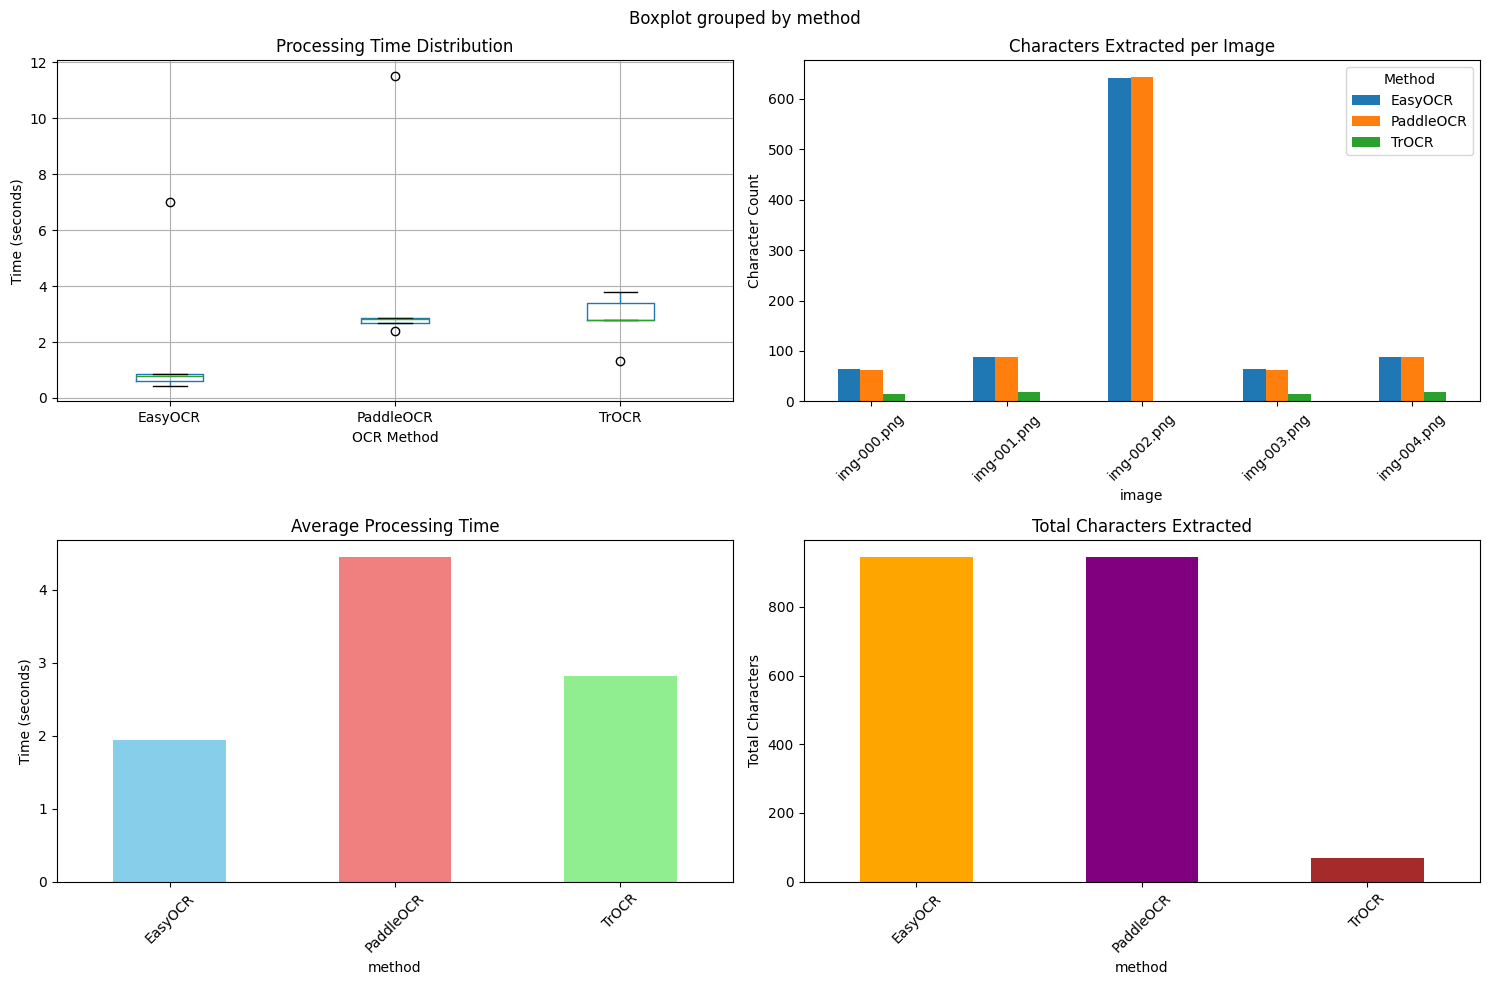


🏆 PERFORMANCE RANKINGS:

⚡ FASTEST (avg time):
   1. EasyOCR: 1.940s
   2. TrOCR: 2.813s
   3. PaddleOCR: 4.453s

📝 MOST TEXT EXTRACTED:
   1. EasyOCR: 946 characters
   2. PaddleOCR: 946 characters
   3. TrOCR: 69 characters

🧹 Cleanup completed

📋 DETAILED RESULTS:
      image    method  processing_time  char_count  word_count  success
img-000.png   EasyOCR            0.614          64          10     True
img-000.png PaddleOCR            2.693          63          10     True
img-000.png     TrOCR            2.796          15           2     True
img-001.png   EasyOCR            0.794          88          11     True
img-001.png PaddleOCR            2.861          88          11     True
img-001.png     TrOCR            3.382          19           2     True
img-002.png   EasyOCR            7.015         642          85     True
img-002.png PaddleOCR           11.520         644          85     True
img-002.png     TrOCR            1.332           1           1     True
img-003.png

In [ ]:
# COMPLETE OCR COMPARISON WITH TIMING AND GRAPHS
import os
import subprocess
import tempfile
import glob
import time
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

pdf_path = "/home/nahuel/Documents/tesis/data/sedici/pdfs/10915-95278.pdf"
print("🔍 OCR PERFORMANCE & QUALITY COMPARISON")
print(f"📄 PDF: {os.path.basename(pdf_path)}")
print("=" * 60)

# Extract images using pdfimages (same as paddletest.py)
def extract_images_simple(pdf_path):
    temp_dir = tempfile.mkdtemp(prefix="pdfimgs_")
    temp_prefix = os.path.join(temp_dir, "img")
    
    cmd = ["pdfimages", "-png", pdf_path, temp_prefix]
    result = subprocess.run(cmd, capture_output=True, text=True)
    
    if result.returncode != 0:
        print(f"❌ pdfimages failed: {result.stderr}")
        return [], temp_dir
    
    images = glob.glob(f"{temp_prefix}-*.png")
    images.sort()
    return images, temp_dir

# Extract images
image_files, temp_dir = extract_images_simple(pdf_path)
print(f"📷 Found {len(image_files)} images")

# Initialize OCR methods
ocr_methods = {}

# EasyOCR
if EASYOCR_AVAILABLE:
    import easyocr
    print("🔧 Initializing EasyOCR...")
    ocr_methods['EasyOCR'] = easyocr.Reader(['en', 'es'])

# PaddleOCR  
if PADDLEOCR_AVAILABLE:
    from paddleocr import PaddleOCR
    print("🔧 Initializing PaddleOCR...")
    ocr_methods['PaddleOCR'] = PaddleOCR(use_textline_orientation=True, lang='es')

# TrOCR
if TROCR_AVAILABLE:
    from transformers import TrOCRProcessor, VisionEncoderDecoderModel
    import torch
    print("🔧 Initializing TrOCR...")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    ocr_methods['TrOCR'] = {
        'processor': TrOCRProcessor.from_pretrained('microsoft/trocr-base-printed'),
        'model': VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-printed').to(device)
    }

# Store results for analysis
results_data = []

# Process each image with each OCR method
for img_idx, img_path in enumerate(image_files, 1):
    img_name = os.path.basename(img_path)
    
    # Load image
    with Image.open(img_path) as img:
        img_size = f"{img.size[0]}x{img.size[1]}"
        print(f"\n📷 IMAGE {img_idx}: {img_name} ({img_size})")
        print("-" * 50)
        
        # Test each OCR method
        for method_name, ocr_engine in ocr_methods.items():
            print(f"\n🔍 {method_name}:")
            
            # Measure time
            start_time = time.time()
            
            try:
                if method_name == 'EasyOCR':
                    import numpy as np
                    img_array = np.array(img)
                    results = ocr_engine.readtext(img_array)
                    text = ' '.join([result[1] for result in results])
                
                elif method_name == 'PaddleOCR':
                    result = ocr_engine.predict(img_path)
                    if result and result[0]:
                        data = result[0]
                        if isinstance(data, dict) and "rec_texts" in data:
                            text = ' '.join(data["rec_texts"])
                        else:
                            text = ""
                    else:
                        text = ""
                
                elif method_name == 'TrOCR':
                    if img.mode != 'RGB':
                        img_rgb = img.convert('RGB')
                    else:
                        img_rgb = img
                    
                    pixel_values = ocr_methods['TrOCR']['processor'](img_rgb, return_tensors="pt").pixel_values.to(device)
                    with torch.no_grad():
                        generated_ids = ocr_methods['TrOCR']['model'].generate(pixel_values)
                        text = ocr_methods['TrOCR']['processor'].batch_decode(generated_ids, skip_special_tokens=True)[0]
                
                processing_time = time.time() - start_time
                
                # Calculate quality metrics
                char_count = len(text)
                word_count = len(text.split()) if text.strip() else 0
                
                # Print results
                if text.strip():
                    print(f'⏱️  {processing_time:.3f}s | 📝 {char_count} chars | 🔤 {word_count} words')
                    print(f'"{text}"')
                else:
                    print(f'⏱️  {processing_time:.3f}s | ❌ No text extracted')
                    text = ""
                
                # Store results
                results_data.append({
                    'image': img_name,
                    'image_size': img_size,
                    'method': method_name,
                    'processing_time': processing_time,
                    'text': text,
                    'char_count': char_count,
                    'word_count': word_count,
                    'success': bool(text.strip())
                })
                    
            except Exception as e:
                processing_time = time.time() - start_time
                print(f'⏱️  {processing_time:.3f}s | ❌ Error: {e}')
                
                # Store error result
                results_data.append({
                    'image': img_name,
                    'image_size': img_size,
                    'method': method_name,
                    'processing_time': processing_time,
                    'text': '',
                    'char_count': 0,
                    'word_count': 0,
                    'success': False
                })

# Create DataFrame for analysis
df = pd.DataFrame(results_data)

# Generate comparison graphs
print(f"\n{'='*60}")
print("📊 PERFORMANCE ANALYSIS")
print(f"{'='*60}")

# Summary statistics
summary = df.groupby('method').agg({
    'processing_time': ['mean', 'std', 'min', 'max'],
    'char_count': ['sum', 'mean'],
    'word_count': ['sum', 'mean'],
    'success': ['sum', 'count']
}).round(3)

print("\n📈 SUMMARY STATISTICS:")
print(summary)

# Calculate success rate
success_rate = df.groupby('method')['success'].agg(['sum', 'count'])
success_rate['success_rate'] = (success_rate['sum'] / success_rate['count'] * 100).round(1)
print(f"\n✅ SUCCESS RATES:")
for method, row in success_rate.iterrows():
    print(f"   {method}: {row['success_rate']}% ({row['sum']}/{row['count']} images)")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('OCR Methods Comparison', fontsize=16, fontweight='bold')

# 1. Processing Time by Method
df.boxplot(column='processing_time', by='method', ax=axes[0,0])
axes[0,0].set_title('Processing Time Distribution')
axes[0,0].set_xlabel('OCR Method')
axes[0,0].set_ylabel('Time (seconds)')

# 2. Characters Extracted per Image
pivot_chars = df.pivot(index='image', columns='method', values='char_count')
pivot_chars.plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Characters Extracted per Image')
axes[0,1].set_ylabel('Character Count')
axes[0,1].legend(title='Method')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Average Processing Time
avg_times = df.groupby('method')['processing_time'].mean()
avg_times.plot(kind='bar', ax=axes[1,0], color=['skyblue', 'lightcoral', 'lightgreen'])
axes[1,0].set_title('Average Processing Time')
axes[1,0].set_ylabel('Time (seconds)')
axes[1,0].tick_params(axis='x', rotation=45)

# 4. Total Text Extracted
total_chars = df.groupby('method')['char_count'].sum()
total_chars.plot(kind='bar', ax=axes[1,1], color=['orange', 'purple', 'brown'])
axes[1,1].set_title('Total Characters Extracted')
axes[1,1].set_ylabel('Total Characters')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Performance ranking
print(f"\n🏆 PERFORMANCE RANKINGS:")
speed_ranking = df.groupby('method')['processing_time'].mean().sort_values()
quality_ranking = df.groupby('method')['char_count'].sum().sort_values(ascending=False)

print(f"\n⚡ FASTEST (avg time):")
for i, (method, time) in enumerate(speed_ranking.items(), 1):
    print(f"   {i}. {method}: {time:.3f}s")

print(f"\n📝 MOST TEXT EXTRACTED:")
for i, (method, chars) in enumerate(quality_ranking.items(), 1):
    print(f"   {i}. {method}: {chars} characters")

# Cleanup
import shutil
shutil.rmtree(temp_dir)
print(f"\n🧹 Cleanup completed")

# Show detailed results table
print(f"\n📋 DETAILED RESULTS:")
display_df = df[['image', 'method', 'processing_time', 'char_count', 'word_count', 'success']].copy()
display_df['processing_time'] = display_df['processing_time'].round(3)
print(display_df.to_string(index=False))

In [9]:
# Statistical summary
if not results_df.empty:
    # Filter out failed tests
    valid_results = results_df[results_df['processing_time'].notna()]
    
    if not valid_results.empty:
        summary = valid_results.groupby('ocr_method').agg({
            'processing_time': ['mean', 'std', 'min', 'max'],
            'words_extracted': 'mean',
            'ocr_extractions': 'mean',
            'text_length': 'mean'
        }).round(3)
        
        print("\nPerformance Summary:")
        print(summary)

NameError: name 'results_df' is not defined

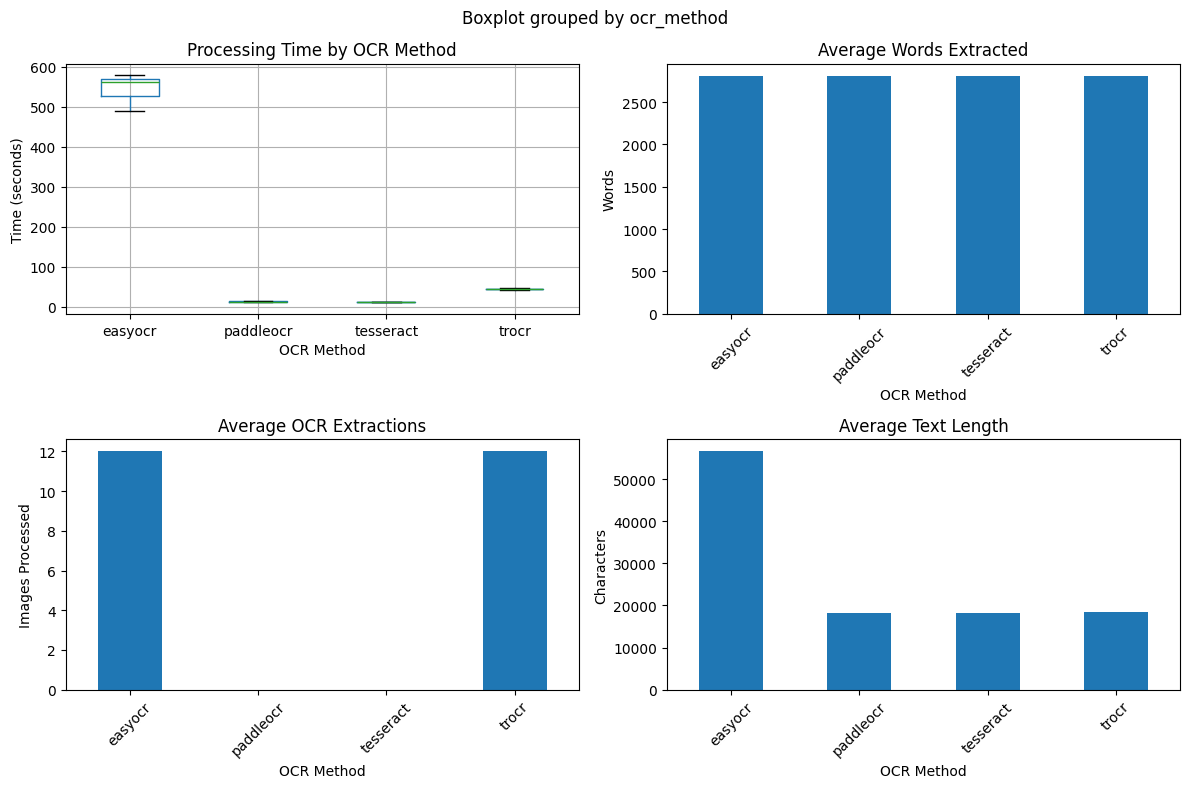

In [ ]:
# Visualization
if not results_df.empty:
    valid_results = results_df[results_df['processing_time'].notna()]
    
    if not valid_results.empty and len(valid_results['ocr_method'].unique()) > 1:
        plt.figure(figsize=(12, 8))
        
        # Processing time comparison
        plt.subplot(2, 2, 1)
        valid_results.boxplot(column='processing_time', by='ocr_method', ax=plt.gca())
        plt.title('Processing Time by OCR Method')
        plt.xlabel('OCR Method')
        plt.ylabel('Time (seconds)')
        
        # Words extracted
        plt.subplot(2, 2, 2)
        method_means = valid_results.groupby('ocr_method')['words_extracted'].mean()
        method_means.plot(kind='bar')
        plt.title('Average Words Extracted')
        plt.xlabel('OCR Method')
        plt.ylabel('Words')
        plt.xticks(rotation=45)
        
        # OCR extractions
        plt.subplot(2, 2, 3)
        ocr_means = valid_results.groupby('ocr_method')['ocr_extractions'].mean()
        ocr_means.plot(kind='bar')
        plt.title('Average OCR Extractions')
        plt.xlabel('OCR Method')
        plt.ylabel('Images Processed')
        plt.xticks(rotation=45)
        
        # Text length
        plt.subplot(2, 2, 4)
        text_means = valid_results.groupby('ocr_method')['text_length'].mean()
        text_means.plot(kind='bar')
        plt.title('Average Text Length')
        plt.xlabel('OCR Method')
        plt.ylabel('Characters')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough valid results for visualization")

## Installation Instructions

### Option 1: Use requirements.txt
```bash
pip install -r requirements.txt
```

### Option 2: Install manually
```bash
# Basic dependencies
pip install pdfplumber pandas matplotlib Pillow numpy

# OCR libraries (install what you want to test)
pip install easyocr              # EasyOCR 
pip install paddlepaddle paddleocr  # PaddleOCR
pip install transformers torch torchvision  # TrOCR (fastest)

# Optional: for image preprocessing
pip install opencv-python
```

### Option 3: Auto-install (uncomment lines in cell 1)

### Speed Comparison:
1. **TrOCR** (fastest) - Transformer-based, GPU accelerated
2. **EasyOCR** - Good balance of speed/accuracy
3. **PaddleOCR** - Good for complex layouts